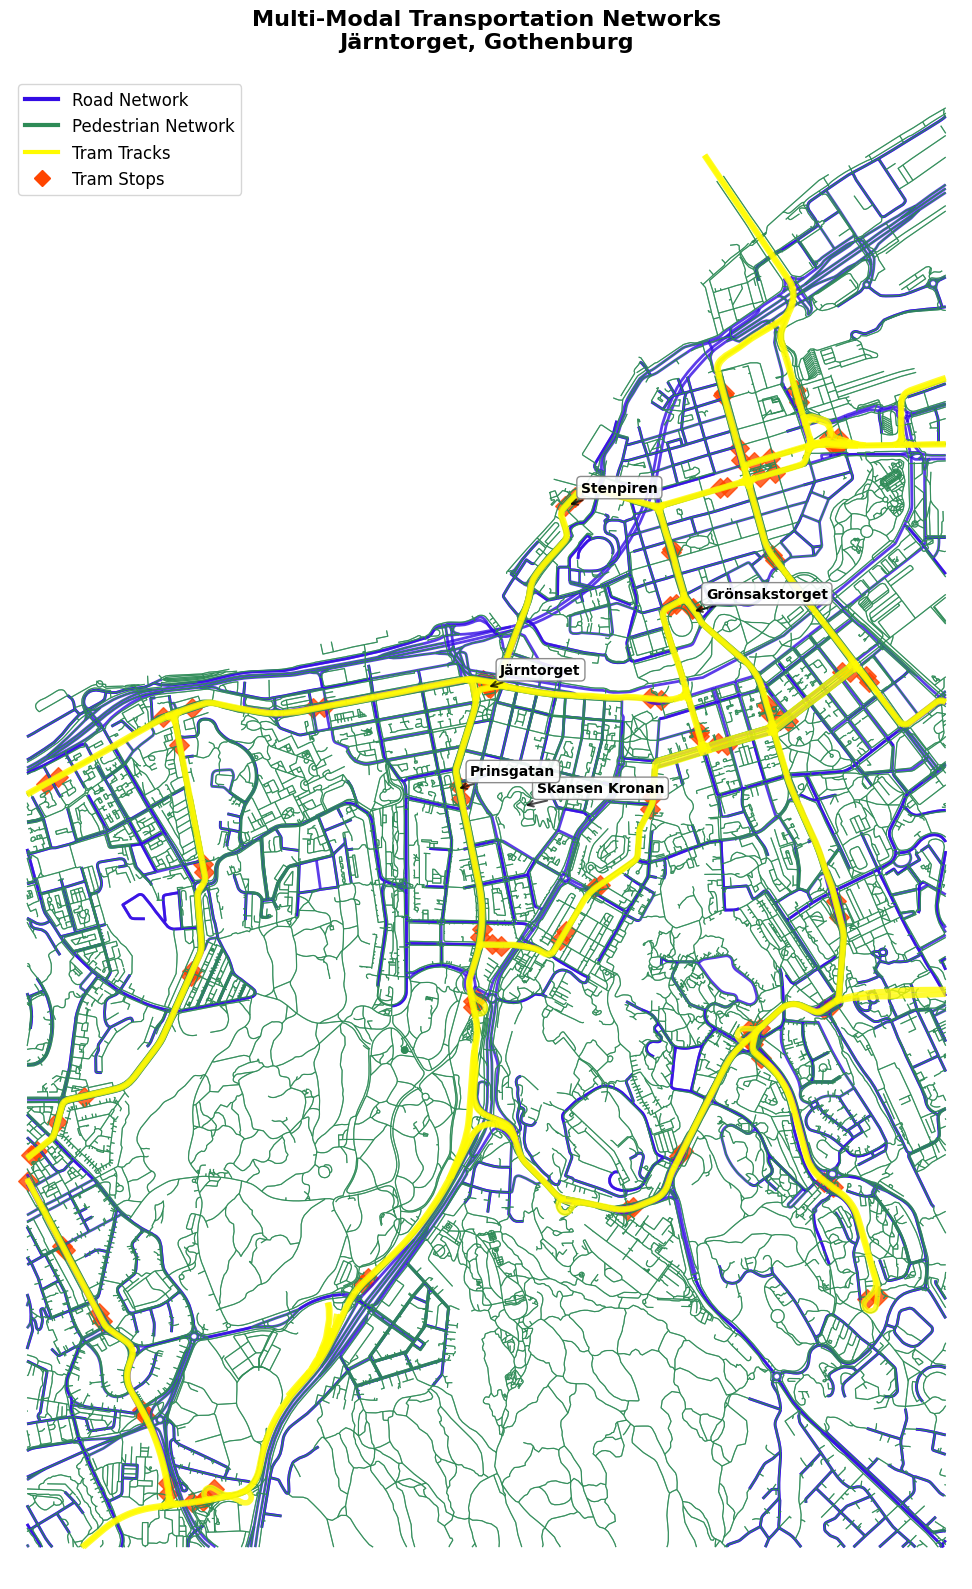

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely.geometry import Polygon, Point
import numpy as np

# Define the center point and radius
JARNTORGET_CENTER = (57.699972, 11.952843)
RADIUS_METERS = 3000

# Define colors once
DRIVE_COLOR = "#330CE4"
PEDESTRIAN_COLOR = '#2E8B57'
TRAM_TRACK_COLOR = "#FFFB00"
TRAM_STOP_COLOR = '#FF4500'
BACKGROUND_COLOR = '#F5F5F5'

# Configure osmnx
ox.settings.log_console = True
ox.settings.use_cache = True

# Define exclusion polygon for the river area
exclusion_polygon = Polygon([
    (11.919817, 57.699166),
    (11.948687, 57.703883),  
    (11.956237, 57.709494),
    (11.967546, 57.715251),
    (11.981203, 57.720014),
    (11.990000, 57.730000),
    (11.900000, 57.730000),
    (11.919817, 57.699166)
])

# Create square clipping boundary
center_lon, center_lat = JARNTORGET_CENTER[1], JARNTORGET_CENTER[0]
radius_degrees = RADIUS_METERS / 111320  # Approximate conversion

# Define square boundaries
min_lon = center_lon - radius_degrees
max_lon = center_lon + radius_degrees
min_lat = center_lat - radius_degrees
max_lat = center_lat + radius_degrees

square_boundary = Polygon([
    (min_lon, min_lat),
    (max_lon, min_lat),
    (max_lon, max_lat),
    (min_lon, max_lat)
])

# Get networks with larger area initially, then clip to square
G_drive = ox.graph_from_point(
    JARNTORGET_CENTER, 
    dist=RADIUS_METERS * 1.5,  # Get more than needed for clean square
    network_type='drive'
)

G_pedestrian = ox.graph_from_point(
    JARNTORGET_CENTER, 
    dist=RADIUS_METERS * 1.5,  # Get more than needed for clean square
    network_type='walk'
)

# Get tram features with larger area
tram_features = ox.features_from_point(
    JARNTORGET_CENTER,
    dist=RADIUS_METERS * 1.5,  # Get more than needed for clean square
    tags={'railway': ['tram', 'tram_stop', 'light_rail']}
)

# Convert graphs to GeoDataFrames
drive_edges_gdf = ox.graph_to_gdfs(G_drive, nodes=False, edges=True)
pedestrian_edges_gdf = ox.graph_to_gdfs(G_pedestrian, nodes=False, edges=True)

# Function to clip geometries to square
def clip_to_square(geom):
    if geom.intersects(square_boundary):
        if geom.geom_type == 'Point':
            # For points, keep if inside square
            return geom if square_boundary.contains(geom) else None
        else:
            # For lines, clip to square boundary
            clipped = geom.intersection(square_boundary)
            # Only return if we have a meaningful geometry left
            if not clipped.is_empty and clipped.geom_type in ['LineString', 'MultiLineString']:
                return clipped
    return None

# Clip all networks to square
drive_edges_clipped = drive_edges_gdf.copy()
drive_edges_clipped['geometry'] = drive_edges_clipped.geometry.apply(clip_to_square)
drive_edges_clipped = drive_edges_clipped[drive_edges_clipped.geometry.notna()]

pedestrian_edges_clipped = pedestrian_edges_gdf.copy()
pedestrian_edges_clipped['geometry'] = pedestrian_edges_clipped.geometry.apply(clip_to_square)
pedestrian_edges_clipped = pedestrian_edges_clipped[pedestrian_edges_clipped.geometry.notna()]

# Clip tram features
if len(tram_features) > 0:
    tram_features_clipped = tram_features.copy()
    tram_features_clipped['geometry'] = tram_features_clipped.geometry.apply(clip_to_square)
    tram_features_clipped = tram_features_clipped[tram_features_clipped.geometry.notna()]

# Apply river exclusion to all clipped networks
drive_edges_final = drive_edges_clipped[
    drive_edges_clipped.geometry.apply(lambda geom: not exclusion_polygon.contains(geom.centroid))
]

pedestrian_edges_final = pedestrian_edges_clipped[
    pedestrian_edges_clipped.geometry.apply(lambda geom: not exclusion_polygon.contains(geom.centroid))
]

if len(tram_features) > 0:
    tram_features_final = tram_features_clipped[
        tram_features_clipped.geometry.apply(
            lambda geom: not exclusion_polygon.contains(geom.centroid if geom.geom_type != 'Point' else geom)
        )
    ]

# Define custom POIs with coordinates and labels
custom_pois = [
    # Format: (latitude, longitude, label)
    (57.699972, 11.952843, "Järntorget"),
    (57.696257, 11.954979, "Skansen Kronan"),
    (57.702356, 11.964901, "Grönsakstorget"),
    (57.696783, 11.951081, "Prinsgatan"),
    (57.705685, 11.957579, "Stenpiren")
]

# Create a professional-looking overlay plot
fig, ax = plt.subplots(figsize=(16, 16))

# Plot final drive network
drive_edges_final.plot(
    ax=ax,
    linewidth=2, 
    color=DRIVE_COLOR,
    alpha=0.8
)

# Plot final pedestrian network
pedestrian_edges_final.plot(
    ax=ax,
    linewidth=0.8, 
    color=PEDESTRIAN_COLOR,
    alpha=0.8
)

# Plot final tram features
if len(tram_features) > 0 and 'tram_features_final' in locals():
    # Tram tracks
    line_tram = tram_features_final[tram_features_final.geometry.type.isin(['LineString', 'MultiLineString'])]
    if len(line_tram) > 0:
        line_tram.plot(ax=ax, color=TRAM_TRACK_COLOR, linewidth=4, alpha=0.8)
    
    # Tram stops
    point_tram = tram_features_final[tram_features_final.geometry.type == 'Point']
    if len(point_tram) > 0:
        point_tram.plot(ax=ax, color=TRAM_STOP_COLOR, markersize=100, marker='D', alpha=0.8)

# Add annotations only (no points)
for lat, lon, label in custom_pois:
    poi_point = Point(lon, lat)
    # Only show annotations within the square
    if square_boundary.contains(poi_point):
        ax.annotate(
            text=label,
            xy=(lon, lat),
            xytext=(10, 10),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle='round,pad=0.3',
                facecolor='white',
                edgecolor='gray',
                alpha=0.9
            ),
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle='arc3,rad=0',
                color='black',
                alpha=0.7,
                lw=1.5
            )
        )

# Calculate the actual bounds of our data to remove empty space
all_geometries = []
all_geometries.extend(drive_edges_final.geometry.tolist())
all_geometries.extend(pedestrian_edges_final.geometry.tolist())

if len(tram_features) > 0 and 'tram_features_final' in locals():
    all_geometries.extend(tram_features_final.geometry.tolist())

# Get the bounds of all geometries
if all_geometries:
    # Create a union of all bounds
    bounds = [geom.bounds for geom in all_geometries if geom is not None]
    if bounds:
        minx = min(b[0] for b in bounds)
        miny = min(b[1] for b in bounds)
        maxx = max(b[2] for b in bounds)
        maxy = max(b[3] for b in bounds)
        
        # Add a small margin
        margin = 0.001  # ~100 meters
        plot_min_lon = minx - margin
        plot_max_lon = maxx + margin
        plot_min_lat = miny - margin
        plot_max_lat = maxy + margin
        
        # Set the plot limits to the actual data bounds
        ax.set_xlim(plot_min_lon, plot_max_lon)
        ax.set_ylim(plot_min_lat, plot_max_lat)

# Create custom legend
legend_elements = [
    Line2D([0], [0], color=DRIVE_COLOR, lw=3, label='Road Network'),
    Line2D([0], [0], color=PEDESTRIAN_COLOR, lw=3, label='Pedestrian Network'),
    Line2D([0], [0], color=TRAM_TRACK_COLOR, lw=3, label='Tram Tracks'),
    Line2D([0], [0], color=TRAM_STOP_COLOR, marker='D', lw=0, markersize=8, label='Tram Stops')
]

ax.legend(handles=legend_elements, loc='upper left', fontsize=12)
ax.set_title(f"Multi-Modal Transportation Networks\nJärntorget, Gothenburg", 
             fontsize=16, fontweight='bold', pad=20)

# Remove axis and set background
ax.set_facecolor(BACKGROUND_COLOR)
ax.set_axis_off()

plt.tight_layout()
plt.show()

In [9]:
import os
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon, Point

# ---------------------------
# CONFIG
# ---------------------------
RAW_DIR = "../../raw/osm"
OUT_DIR = "../../processed/networks"
os.makedirs(OUT_DIR, exist_ok=True)

JARNTORGET_CENTER = (57.699972, 11.952843)
RADIUS_METERS = 3000
TARGET_CRS = "EPSG:3006"  # SWEREF99 TM

# ---------------------------
# SQUARE BOUNDARY & EXCLUSION POLYGON
# ---------------------------
center_lon, center_lat = JARNTORGET_CENTER[1], JARNTORGET_CENTER[0]
radius_deg = RADIUS_METERS / 111320  # approx. conversion
square_boundary = Polygon([
    (center_lon - radius_deg, center_lat - radius_deg),
    (center_lon + radius_deg, center_lat - radius_deg),
    (center_lon + radius_deg, center_lat + radius_deg),
    (center_lon - radius_deg, center_lat + radius_deg)
])

# River exclusion
exclusion_polygon = Polygon([
    (11.919817, 57.699166),
    (11.948687, 57.703883),  
    (11.956237, 57.709494),
    (11.967546, 57.715251),
    (11.981203, 57.720014),
    (11.990000, 57.730000),
    (11.900000, 57.730000),
    (11.919817, 57.699166)
])

# ---------------------------
# CONFIGURE OSMNX
# ---------------------------
ox.settings.log_console = True
ox.settings.use_cache = True

# ---------------------------
# DOWNLOAD NETWORKS
# ---------------------------
G_drive = ox.graph_from_point(JARNTORGET_CENTER, dist=RADIUS_METERS*1.5, network_type='drive')
G_walk = ox.graph_from_point(JARNTORGET_CENTER, dist=RADIUS_METERS*1.5, network_type='walk')

# Tram features
tram_features = ox.features_from_point(
    JARNTORGET_CENTER,
    dist=RADIUS_METERS*1.5,
    tags={'railway': ['tram', 'tram_stop', 'light_rail']}
)

# ---------------------------
# ADD EDGE ATTRIBUTES
# ---------------------------
G_drive = ox.add_edge_speeds(G_drive)
G_drive = ox.add_edge_travel_times(G_drive)

# ---------------------------
# CLIP GRAPHS TO SQUARE
# ---------------------------
G_drive = ox.truncate.truncate_graph_polygon(G_drive, square_boundary)
G_walk = ox.truncate.truncate_graph_polygon(G_walk, square_boundary)

# ---------------------------
# REMOVE EDGES OVER RIVER
# ---------------------------
def remove_edges_over_polygon(G, polygon):
    G_clean = G.copy()
    to_remove = []
    for u, v, k, data in G_clean.edges(keys=True, data=True):
        geom = data.get("geometry")
        if geom is None:
            continue
        centroid = geom.centroid if geom.geom_type != 'Point' else geom
        if polygon.contains(centroid):
            to_remove.append((u, v, k))
    G_clean.remove_edges_from(to_remove)
    # Remove isolated nodes
    isolated = list(nx.isolates(G_clean))
    G_clean.remove_nodes_from(isolated)
    return G_clean

G_drive = remove_edges_over_polygon(G_drive, exclusion_polygon)
G_walk = remove_edges_over_polygon(G_walk, exclusion_polygon)

def keep_largest_component(G, strongly=False):
    if strongly:
        # largest strongly connected component
        largest_nodes = max(nx.strongly_connected_components(G), key=len)
    else:
        # convert to undirected first
        G_undirected = G.to_undirected()
        largest_nodes = max(nx.connected_components(G_undirected), key=len)
    return G.subgraph(largest_nodes).copy()


G_drive = keep_largest_component(G_drive, strongly=True)
G_walk = keep_largest_component(G_walk, strongly=False)



# ---------------------------
# CONVERT TO GEODATAFRAMES
# ---------------------------
drive_nodes, drive_edges = ox.graph_to_gdfs(G_drive)
walk_nodes, walk_edges = ox.graph_to_gdfs(G_walk)

# ---------------------------
# CLIP TRAM FEATURES
# ---------------------------
if len(tram_features) > 0:
    tram_features_clipped = tram_features.copy()
    tram_features_clipped['geometry'] = tram_features_clipped.geometry.apply(
        lambda g: g.intersection(square_boundary) if g.intersects(square_boundary) else None
    )
    tram_features_clipped = tram_features_clipped[tram_features_clipped.geometry.notna()]
    tram_features_clipped = tram_features_clipped[
        ~tram_features_clipped.geometry.apply(
            lambda g: exclusion_polygon.contains(g.centroid if g.geom_type != 'Point' else g)
        )
    ]
else:
    tram_features_clipped = gpd.GeoDataFrame(columns=["geometry"])

# ---------------------------
# SAVE DATA
# ---------------------------
drive_nodes.to_file(os.path.join(OUT_DIR, "drive_nodes_clean.gpkg"), driver="GPKG")
drive_edges.to_file(os.path.join(OUT_DIR, "drive_edges_clean.gpkg"), driver="GPKG")

walk_nodes.to_file(os.path.join(OUT_DIR, "walk_nodes_clean.gpkg"), driver="GPKG")
walk_edges.to_file(os.path.join(OUT_DIR, "walk_edges_clean.gpkg"), driver="GPKG")

if len(tram_features_clipped) > 0:
    tram_features_clipped.to_file(os.path.join(OUT_DIR, "tram_features_clean.gpkg"), driver="GPKG")

# ---------------------------
# SUMMARY
# ---------------------------
print("=== Preprocessing Complete ===")
print(f"Drive: {G_drive.number_of_nodes()} nodes, {G_drive.number_of_edges()} edges")
print(f"Pedestrian: {G_walk.number_of_nodes()} nodes, {G_walk.number_of_edges()} edges")
print(f"Tram features: {len(tram_features_clipped)}")

=== Preprocessing Complete ===
Drive: 1171 nodes, 2414 edges
Pedestrian: 14194 nodes, 37660 edges
Tram features: 383


In [17]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

print("Extracting Göta Älv by geometry (area-based, with reprojection)…")

# Step 1: query all water polygons
layers = []

try:
    wr = ox.features_from_place("Göteborg, Sweden", tags={"water": "river"})
    layers.append(wr)
    print(f"water=river: {len(wr)} features")
except:
    print("water=river failed")

try:
    nw = ox.features_from_place("Göteborg, Sweden", tags={"natural": "water"})
    layers.append(nw)
    print(f"natural=water: {len(nw)} features")
except:
    print("natural=water failed")


# Merge
merged = gpd.GeoDataFrame(pd.concat(layers, ignore_index=True),
                          crs=layers[0].crs)

# Keep only polygons
merged = merged[merged.geometry.type.isin(["Polygon", "MultiPolygon"])]

# -----------------------------------------------------------
# NEW: Reproject to Swedish CRS (meters) for area calculation
# -----------------------------------------------------------
SWEDEN_EPSG = 3006
epsg_3006 = 3006
merged_m = merged.to_crs(SWEDEN_EPSG)

# Compute area in m²
merged_m["area"] = merged_m.area

# Select the largest polygons
river = merged_m.sort_values("area", ascending=False).head(2)

print("Largest polygons by area (m²):")
print(river[["area"]])

# Reproject back to WGS84 for saving and plotting
river = river.to_crs(4326)

# Save
OUT_DIR = "../../processed/networks"
river_file = f"{OUT_DIR}/gota_alv.gpkg"
river.to_file(river_file, driver="GPKG")

print("Saved Göta Älv polygons to:", river_file)


Extracting Göta Älv by geometry (area-based, with reprojection)…
water=river: 16 features
natural=water: 831 features
Largest polygons by area (m²):
            area
44  7.590459e+06
4   7.590459e+06
Saved Göta Älv polygons to: ../../processed/networks/gota_alv.gpkg
